In [1]:
import matplotlib.pyplot as plt
import numpy as np
import arby

#autoreload permite que jupyter vea las modif de los script de forma automática
%load_ext autoreload
%autoreload 2

[8. 0. 0.]
[1.94864703 0.         0.        ]


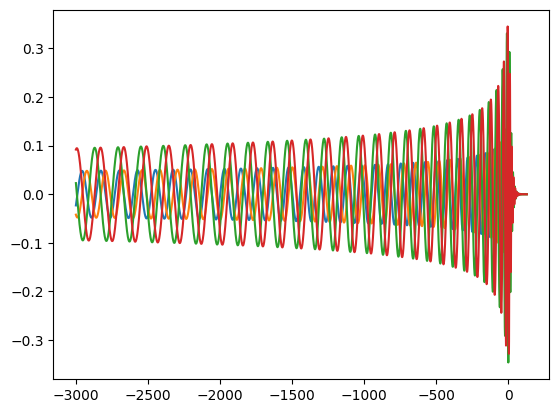

In [4]:
path = "tests/data/"
q_train = np.load(path+"q_train_1d_seed=1.npy")
q_test = np.load(path+"q_test_1d_seed=1.npy")
ts_train = np.load(path+"ts_train_1d_seed=1.npy")
ts_test = np.load(path+"ts_test_1d_seed=1.npy")
times = np.load(path+"times_1d_seed=1.npy")

for idx in [1,-1]:
    print(q_train[idx])
    q_train[idx]
    plt.plot(times,np.imag(ts_train[idx]))
    plt.plot(times,np.real(ts_train[idx]));

In [5]:
%%time
from skreducedmodel.reducedbasis import ReducedBasis

rb = ReducedBasis(
                 seed_global_rb = 0,
                 greedy_tol = 1e-16,
                 lmax = 1, 
                 nmax = 25,
                 normalize = True,
                 integration_rule="riemann",
                 )

rb.fit(
       training_set = ts_train, 
       parameters = q_train, 
       physical_points = times,
       )

len(rb.indices),rb.indices

#plt.yscale("log")
#plt.plot(rb.errors,"o")

0 0.9711444615591067 66
1 0.9298876282729054 357
2 0.8874877691824682 251
3 0.8732681693741015 107
4 0.8471938634685973 1
5 0.8209940749935143 109
6 0.12773399696049675 281
7 0.014012287802307354 459
8 0.0010001689859362303 332
9 6.649743908386779e-05 157
10 3.506468114275807e-06 327
11 1.9679490921736064e-07 313
12 5.29893676965627e-08 258
13 5.982612861197699e-09 412
14 1.6060722518255677e-10 396
15 1.6810122254768854e-11 63
16 3.630522451354826e-12 72
17 1.8996064069292052e-13 493
18 2.2501900486463122e-14 415
19 8.829309621952439e-15 499
20 8.614931516080845e-15 499
21 8.614931516080845e-15 499
CPU times: user 5.42 s, sys: 10 s, total: 15.5 s
Wall time: 3.16 s


(21,
 [0,
  66,
  357,
  251,
  107,
  1,
  109,
  281,
  459,
  332,
  157,
  327,
  313,
  258,
  412,
  396,
  63,
  72,
  493,
  415,
  499])

In [34]:
rb.errors

array([9.71144462e-01, 9.29887628e-01, 8.87487769e-01, 8.73268169e-01,
       8.47193863e-01, 8.20994075e-01, 1.27733997e-01, 1.40122878e-02,
       1.00016899e-03, 6.64974391e-05, 3.50646811e-06, 1.96794909e-07,
       5.29893677e-08, 5.98261286e-09, 1.60607225e-10, 1.68101223e-11,
       3.63052245e-12, 1.89960641e-13, 2.25019005e-14, 8.82930962e-15,
       8.61493152e-15])

In [36]:
rb.transform(ts_test[0],q_test[0])

array([-5.42947498e-02+2.50671901e-03j, -5.42831833e-02+2.75510401e-03j,
       -5.42704805e-02+3.00343833e-03j, ...,
       -5.11858163e-07-1.18880357e-06j, -8.23361241e-07-2.03673470e-06j,
       -1.09079970e-06-2.86282479e-06j])

In [43]:
np.array_equal(projected_f,rb.transform(ts_test[0],q_test[0]))

True

--------

In [37]:
%%time
arby_model = arby.reduced_basis(ts_train, times, greedy_tol=1e-16, normalize=True)

arby_model.errors,len(arby_model.errors)

CPU times: user 6.88 s, sys: 11.4 s, total: 18.2 s
Wall time: 3.22 s


(array([9.71144462e-01, 9.29887628e-01, 8.87487769e-01, 8.73268169e-01,
        8.47193863e-01, 8.20994075e-01, 1.27733997e-01, 1.40122878e-02,
        1.00016899e-03, 6.64974391e-05, 3.50646811e-06, 1.96794909e-07,
        5.29893677e-08, 5.98261286e-09, 1.60607225e-10, 1.68101223e-11,
        3.63052245e-12, 1.89960641e-13, 2.25019005e-14, 8.82930962e-15,
        8.61493152e-15]),
 21)

In [39]:
arby_model.errors==rb.errors

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [40]:
projected_f = arby_model.basis.project(ts_test[0])

In [84]:
def normalize_set(array,domain,rule = "riemann"):
    integration = arby.integrals.Integration(domain, rule)
    norms = integration.norm(array)
    return np.array(
            [
                h if np.allclose(h, 0, atol=1e-15) else h / norms[i]
                for i, h in enumerate(array)
            ]
        )

#normalize with arby code
normalized_ts_train = normalize_set(ts_train,times)
#del ts_train
normalized_ts_test = normalize_set(ts_test,times)
#del ts_test

print(times.shape)
print(q_train.shape,normalized_ts_train.shape)
print(q_test.shape,normalized_ts_test.shape)

(31300,)
(500, 3) (500, 31300)
(500, 3) (500, 31300)


In [17]:
greedy_tol = 1e-16
normalize = True
model = Surrogate()

results = {}
for lmax in range(0,1):
    for nmax in [20,np.inf]:
        
        model.fit(ts_train, q_train, times, greedy_tol, nmax, lmax, normalize)
        
        errors = []
        for q, wf in zip(q_test, ts_test):
            error = np.real(hpg_norm.proj_error_hpgreedy(tree, q, wf/hpg_norm.norm_riemann(wf,dt=0.1), N))
            errors.append(error)

        results[(L_max,N_max)] = {}
        results[(L_max,N_max)]["max_errors"] = np.max(errors)
        results[(L_max,N_max)]["mean_errors"] = np.mean(errors)
        print(f"N_max = {N_max}, L_max = {L_max}. max error = {max_errors[-1]}")

NameError: name 'hpg_norm' is not defined